In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
def spectrogram_stft(X, fs, window=None, nperseg=64, nfft=False):
    window = window or signal.windows.hann(nperseg)
    nfft = nfft or nperseg
    noverlap = nperseg - 1
    f, t, result = signal.stft(X, fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft, detrend='constant')
    result = np.conjugate(result) * result
    return f, t, result.real

def concentration(Dp, window):
    '''Concentration with flat window'''
    C = np.sum(Dp, axis=0)
    c = np.zeros(C.shape)
    for i in range(c.size):
        c[i] = np.sum(C[np.maximum(0, i - window):np.minimum(i + window, c.size)])
    return c

def adaptive_spectrogram(signal, fs, windows, mega_window=256, ret_coefs=False):
    windows = np.array(windows)
    f, t, Sadapt = spectrogram_stft(X, fs, nperseg=windows[0], nfft=mega_window)
    S = np.zeros((windows.size, Sadapt.shape[0], Sadapt.shape[1]))
    c4s = np.zeros((len(windows), len(X) + 1))
    c2s = np.zeros_like(c4s)
    for pp, p in enumerate(windows):
        _, _, S[pp, :, :] = spectrogram_stft(X, fs, nperseg=p, nfft=mega_window)

        c4s[pp] = concentration(S[pp, :, :]**4, mega_window // 2)
        c2s[pp] = concentration(S[pp, :, :]**2, mega_window // 2)
        c2s[pp] *= c2s[pp]
        c2s[c2s == 0] = 1

    C = c4s / c2s
    best_win_pos = C.argmax(0)
    best_win = windows[best_win_pos]
    for i in range(Sadapt.shape[1]):
        Sadapt[:, i] = S[best_win_pos[i], :, i]
    if not ret_coefs:
        return f, t, Sadapt
    else:
        return f, t, Sadapt, (C, c4s, c2s, best_win)

### Test spectrogram

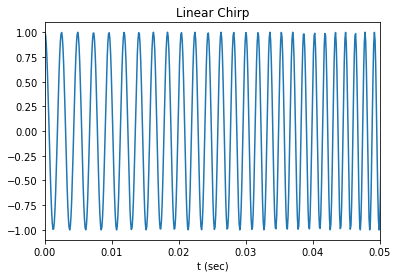

In [3]:
# build hyperbolic chirp signal
from scipy.signal import chirp
fs = 10e3
f0=4e2
f1=4e3
t0=0
t1=0.1
t = np.arange(0, t1, 1/fs)
X = chirp(t, f0=f0, f1=f1, t1=t1, method='hyperbolic')

plt.plot(t, X)
plt.title("Linear Chirp")
plt.xlabel('t (sec)')
plt.xlim(0, t1/2)
plt.show()

In [4]:
windows = np.array([16, 32, 64, 128, 160, 256])
mega_window = 256
f, t, Sadapt, (C, c4s, c2s, best_win) = adaptive_spectrogram(X, fs, windows, mega_window,  ret_coefs=True)

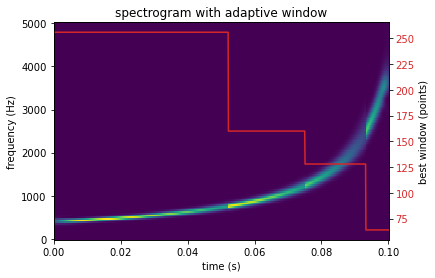

In [5]:
fig, ax1 = plt.subplots()
ax1.pcolormesh(t, f, Sadapt)
ax1.set_title(u"spectrogram with adaptive window")
ax1.set_ylabel('frequency (Hz)')
ax1.set_xlabel('time (s)')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(t, best_win, color='tab:red')
ax2.set_ylabel('best window (points)')
ax2.set_xlabel('time (s)')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.show()

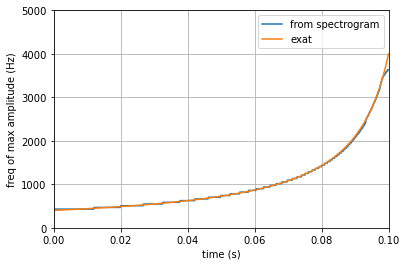

In [6]:
argmax = np.argmax(Sadapt, axis=0)

fig, ax1 = plt.subplots()
ax1.plot(t, f[argmax], label='from spectrogram')
ax1.plot(t, f0*f1*t1 / ((f0 - f1)*t + f1*t1), label='exat')
ax1.set_ylabel('freq of max amplitude (Hz)')
ax1.set_xlabel('time (s)')
ax1.set_ylim(f[0], f[-1])
ax1.set_xlim(t[0], t[-1])
plt.legend()
plt.grid()
plt.show()